In [227]:
import yfinance as yf
import pandas as pd

def create_df_for_multi_companies(
        raw_data_multiindex:pd.MultiIndex, 
        stock_var:str, 
        companies:list[str]):
    
    raw_values = {}
    for company in companies:
        # Transform MultiIndex DF into SingleIndex DF for each company with all prices (Open, Close... Adj. Close)
        raw_data_by_company = raw_data_multiindex.xs(key=company, level='Ticker', axis=1, drop_level=False)
        # Grab only the Datetime and the desired price (e.g., colums -> [Datetime | Open])
        raw_data_series = raw_data_by_company[(stock_var,company)]
        # Make a dictionary of type {company[x] : [Open Values 0, 1, ... N] ... }
        raw_values[company] = raw_data_series.values
    # Create 'df' Dataframe only with "Datetime" Column
    df = pd.DataFrame({'Datetime':raw_data_series.index})
    # Append all columns with values for each company, resulting in [Datetime | Company_values[x] ...]
    df = df.assign(**raw_values)
    return df

def get_finance_df(
        companies:str|list[str], 
        start_date:str, 
        end_date:str, 
        stock_var:str='Adj Close') -> pd.DataFrame:
    
    try:
        # In case companies is a string, transform into a list of 1 object, like: ['company']
        if not isinstance(companies,list):
            companies:list[str] = [companies]
        
        # Download data using yfinance
        raw_data_multiindex:pd.MultiIndex = yf.download(tickers=companies, start=start_date, end=end_date)

        # Transform the raw data into a suitable DF
        df = create_df_for_multi_companies(raw_data_multiindex, stock_var, companies)

        return df
    
    except:
            Exception("Unexpected error: something wrong occurred while creating the finance DF")


def split_train_test_valid_df(df, horizon_pred=1, seq_length=30, size_train_percent=0.75, size_test_percent=0.2):
    N = len(df)-seq_length-horizon_pred
    Ntrain = int(size_train_percent*N)
    Ntest = int(size_test_percent*N)
    
    df_train = df.loc[0:Ntrain]
    df_test = df.loc[Ntrain+1:Ntrain+Ntest]
    df_valid = df.loc[Ntrain+Ntest+1:]

    Nvalid = len(df_valid)
    if (Nvalid < (seq_length+horizon_pred+1)):
        raise ValueError(f"""At least (seq_length+horizon_pred+1) samples are needed for validation. You have seq_length={seq_length}, horizon_pred={horizon_pred} and Nvalid={Nvalid} samples, with Ntrain={Ntrain}, Ntest={Ntest} and N={N}. Try changing the prediction horizon, the sequence/window length, or increasing the number of samples""")

    return (df_train, df_test, df_valid)

def shift_drop_na_in_xy(df, company_inputs, company_output, horizon_pred):
    new_df = pd.concat([df[company_inputs], df[company_output].rename("target").shift(-horizon_pred)],axis='columns').dropna()
    X = new_df[company_inputs].values
    y = new_df["target"].values
    return X, y

In [228]:
train_ratio = 0.8
test_ratio = 0.15
n_epochs = 150
loss_fn = 'mse'

horizon_pred = 1
seq_length = 30

# batch_size = 30
# units_layer1 = 250
# activation_layer1 = 'relu'
# dropout_layer1 = 0.2
units_layer2 = None
# activation_layer2 = None if units_layer2 is None else 'relu'
# dropout_layer2 = None if units_layer2 is None else 0.1
# activation_output = 'relu'

param_grid = {
    'batch_size' : [30],
    'units_layer1' : [250],
    'activation_layer1' : ['relu'],
    'dropout_layer1' : [0.2],
    'units_layer2' : [None],
    'activation_layer2' : [None if units_layer2 is None else 'relu'],
    'dropout_layer2' : [None if units_layer2 is None else 0.1],
    'activation_output' : ['relu'],
    'optim' : ['adam']
}

In [229]:
# from feature_engineering import get_finance_df

# Load dataset
# company_inputs = ['PETR4.SA', 'BZ=F', '6L=F']
# company_inputs = ['PETR4.SA', 'BZ=F']
# company_inputs = ['PETR4.SA', '6L=F']
company_inputs = ['PETR4.SA']
company_output = 'PETR4.SA'
stock_var = 'Adj Close'

end_date = '2024-10-30' 
start_date = '2017-01-01'

df = get_finance_df(company_inputs, start_date, end_date, stock_var)
df = df.interpolate(method='linear')
# df = df.fillna(0)
# df.dropna()

n_inputs = len(company_inputs)

print(df)
print(n_inputs)


[*********************100%***********************]  1 of 1 completed

                      Datetime   PETR4.SA
0    2017-01-02 00:00:00+00:00   4.705652
1    2017-01-03 00:00:00+00:00   4.975281
2    2017-01-04 00:00:00+00:00   4.975281
3    2017-01-05 00:00:00+00:00   5.055527
4    2017-01-06 00:00:00+00:00   5.026639
...                        ...        ...
1947 2024-10-23 00:00:00+00:00  35.660000
1948 2024-10-24 00:00:00+00:00  35.900002
1949 2024-10-25 00:00:00+00:00  36.150002
1950 2024-10-28 00:00:00+00:00  36.090000
1951 2024-10-29 00:00:00+00:00  36.009998

[1952 rows x 2 columns]
1


In [230]:
df_train, df_test, df_valid = split_train_test_valid_df(df=df, 
    horizon_pred=horizon_pred, seq_length=seq_length, 
    size_train_percent=train_ratio, size_test_percent=test_ratio
    )

In [231]:
X_train, y_train = shift_drop_na_in_xy(df_train, company_inputs, company_output, horizon_pred=horizon_pred)
X_test, y_test = shift_drop_na_in_xy(df_test, company_inputs, company_output, horizon_pred=horizon_pred)
X_valid, y_valid = shift_drop_na_in_xy(df_valid, company_inputs, company_output, horizon_pred=horizon_pred)

In [232]:
X_train[0:3], y_train[0:3]

(array([[4.70565176],
        [4.97528076],
        [4.97528076]]),
 array([4.97528076, 4.97528076, 5.05552721]))

In [233]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler

# Normalize the Price column
scalerX = MinMaxScaler()
scalery = MinMaxScaler()
scaled_X_train = scalerX.fit_transform(X_train)
scaled_y_train = scalery.fit_transform(y_train.reshape(-1, 1))

scaled_X_test = scalerX.transform(X_test)
scaled_y_test = scalery.transform(y_test.reshape(-1, 1))

scaled_X_valid = scalerX.transform(X_valid)
scaled_y_valid = scalery.transform(y_valid.reshape(-1, 1))

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Initialize generator with multivariable input and single target
generator_train = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=seq_length, batch_size=batch_size)
generator_test = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=seq_length, batch_size=batch_size)
generator_valid = TimeseriesGenerator(scaled_X_valid, scaled_y_valid, length=seq_length, batch_size=batch_size)


In [234]:
scaled_X_train, scaled_y_train

(array([[0.04786904],
        [0.06118367],
        [0.06118367],
        ...,
        [0.66548425],
        [0.64331067],
        [0.67892272]]),
 array([[0.06118367],
        [0.06118367],
        [0.06514634],
        ...,
        [0.64331067],
        [0.67892272],
        [0.68765784]]))

In [235]:
Xgen_train, ygen_train = generator_train[0]

In [236]:
scalerX.inverse_transform(Xgen_train[0]), scalery.inverse_transform(ygen_train[0].reshape(-1,1)) 

(array([[4.70565176],
        [4.97528076],
        [4.97528076],
        [5.05552721],
        [5.02663946],
        [4.92071199],
        [4.96886015],
        [5.02663946],
        [5.10367441],
        [5.03305769],
        [5.05552721],
        [5.07799625],
        [5.068367  ],
        [5.06194687],
        [5.13577461],
        [5.13256311],
        [5.14861345],
        [5.07157564],
        [5.01379871],
        [4.76342964],
        [4.82120752],
        [4.82120752],
        [4.7794795 ],
        [4.92392254],
        [4.80194855],
        [4.71849251],
        [4.84688663],
        [4.83083534],
        [5.00095892],
        [5.01379871]]),
 array([[5.08441687]]))

In [237]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.regularizers import l1, l2, l1_l2
from scikeras.wrappers import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define the LSTM model
# def custom_lstm(units_layer1, activation_layer1, seq_length, n_inputs, optim='adam', loss_fn='mse', activation_output='relu', dropout_layer1=0.2, dropout_layer2=0.1, kernel_reg_factor=0.01, recur_reg_factor=0.01, bias_reg_factor=0.01, units_layer2=None, activation_layer2=None):

#     # if (units_layer2 is None) or (activation_layer2 is None):
#     # print("layers = 1")
#     model = Sequential([
#             LSTM(units=units_layer1, activation=activation_layer1, input_shape=(seq_length, n_inputs),
#                 kernel_regularizer=l2(kernel_reg_factor), 
#                 recurrent_regularizer=l2(recur_reg_factor), 
#                 bias_regularizer=l2(bias_reg_factor),
#                 recurrent_dropout=dropout_layer1),
#         Dropout(rate=dropout_layer1),
#         Dense(1, activation=activation_output)
#     ])
#     # else:
#     #     print("layers = 2")
#     #     model = Sequential([
#     #         LSTM(units=units_layer1, activation=activation_layer1, input_shape=(seq_length, n_inputs), 
#     #                 kernel_regularizer=l2(kernel_reg_factor), 
#     #                 recurrent_regularizer=l2(recur_reg_factor), 
#     #                 bias_regularizer=l2(bias_reg_factor),
#     #                 recurrent_dropout=dropout_layer1,
#     #                 return_sequences=True),
#     #         Dropout(rate=dropout_layer1),
#     #         LSTM(units=units_layer2, activation=activation_layer2,
#     #                 kernel_regularizer=l2(kernel_reg_factor), 
#     #                 recurrent_regularizer=l2(recur_reg_factor), 
#     #                 bias_regularizer=l2(bias_reg_factor),
#     #                 recurrent_dropout=dropout_layer1),
#     #         Dropout(rate=dropout_layer2),
#     #         Dense(1, activation=activation_output)
#     #     ])

#     model.compile(optimizer=optim, loss=loss_fn)

#     return model

def custom_lstm(units_layer1=250, optim='adam'):
    model = Sequential([
                LSTM(units=units_layer1, activation='relu', input_shape=(seq_length, n_inputs)),
                Dense(1, activation='relu')
    ])
    model.compile(optimizer=optim, loss=loss_fn)
    return model

param_grid = {'units_layer1' : [250]}

model = KerasRegressor(model=custom_lstm, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

grid_result = grid.fit(generator_train, epochs=n_epochs, validation_data=generator_test)


ValueError: Invalid parameter units_layer1 for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(units_layer1=250)`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# import matplotlib.pyplot as plt

# # Plot the predicted prices
# plt.plot(hist['loss'], label="Train Loss")
# plt.plot(hist['val_loss'], label="Test Loss")
# plt.xlabel("Epoch")
# plt.ylabel("MSE")
# plt.legend()
# plt.show()

In [ ]:
X_gen_valid, y_gen_valid = generator_valid[0]
y_pred_scaled = model.predict(X_gen_valid).reshape(-1,)
print(y_pred_scaled)
print(y_gen_valid[1:].reshape(-1,))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
[1.4273677 1.4182088 1.4339939 1.4428105 1.4581946 1.4698324 1.4829152
 1.4891952 1.4936192 1.5076485 1.5214105 1.5395725 1.5468088 1.5379429
 1.5234867 1.519702  1.5350976 1.5429568 1.5402721 1.5437855 1.5422198
 1.5480164 1.5491568 1.5535353 1.5545026 1.558034  1.5453315 1.5294342
 1.5267833 1.5244441]
[1.54066988 1.56803827 1.57716107 1.59492668 1.59348599 1.596367
 1.62613622 1.64246115 1.6703099  1.66454789 1.63237821 1.60741046
 1.61701343 1.66118691 1.66070693 1.64342148 1.65590545 1.64726282
 1.66406791 1.65926643 1.66886939 1.66550823 1.67319071 1.63621917
 1.61269211 1.62709656 1.62469572 1.62277524 1.58628405]


In [ ]:
# y_pred = scalery.inverse_transform(y_pred_scaled.reshape(-1,1))
# y_valid_f = scalery.inverse_transform(y_gen_valid.reshape(-1,1))
y_pred = y_pred_scaled.reshape(-1,1)
y_valid_f = y_gen_valid.reshape(-1,1)
print(y_pred.T, y_valid_f.T)

[[1.4273677 1.4182088 1.4339939 1.4428105 1.4581946 1.4698324 1.4829152
  1.4891952 1.4936192 1.5076485 1.5214105 1.5395725 1.5468088 1.5379429
  1.5234867 1.519702  1.5350976 1.5429568 1.5402721 1.5437855 1.5422198
  1.5480164 1.5491568 1.5535353 1.5545026 1.558034  1.5453315 1.5294342
  1.5267833 1.5244441]] [[1.53922957 1.54066988 1.56803827 1.57716107 1.59492668 1.59348599
  1.596367   1.62613622 1.64246115 1.6703099  1.66454789 1.63237821
  1.60741046 1.61701343 1.66118691 1.66070693 1.64342148 1.65590545
  1.64726282 1.66406791 1.65926643 1.66886939 1.66550823 1.67319071
  1.63621917 1.61269211 1.62709656 1.62469572 1.62277524 1.58628405]]


In [ ]:
from sklearn.metrics import root_mean_squared_error, r2_score

delay = 1
offset = 0

rmse = root_mean_squared_error(y_pred[delay:]+offset, y_valid_f[0:-delay])
r2 = r2_score(y_pred[delay:]+offset, y_valid_f[0:-delay])

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

RMSE: 0.1125
R² Score: -7.5942


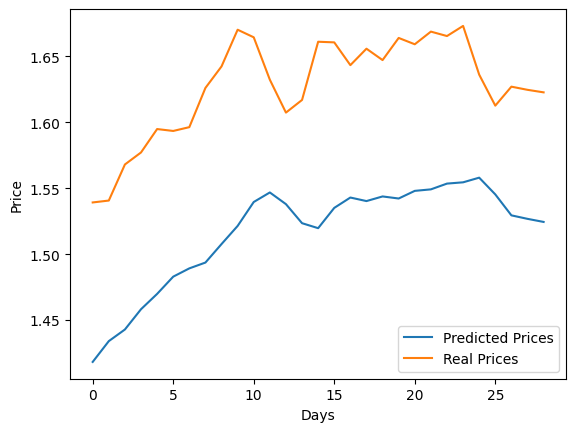

In [ ]:
import matplotlib.pyplot as plt

# Plot the predicted prices
plt.plot(y_pred[delay:]+offset, label="Predicted Prices")
plt.plot(y_valid_f[:-delay], label="Real Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
# import mlflow
# import mlflow.tensorflow

# mlflow.set_tracking_uri(uri="http://127.0.0.1:7777")
# mlflow.set_experiment("LSTM Experiments")

# from sklearn.metrics import root_mean_squared_error, r2_score

# mlflow.tensorflow.autolog()
# with mlflow.start_run():
#     mlflow.tensorflow.log_model(model, "model")

#     # Calculate RMSE and R² score
#     rmse = root_mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     print(f'RMSE: {rmse:.4f}')
#     print(f'R² Score: {r2:.4f}')

#     mlflow.log_metric("RMSE", rmse)
#     mlflow.log_metric("R2-Score", r2)

In [ ]:
# # Predict using the trained model
# future_steps = 10  # Number of days to predict
# future_data = data[-n_steps:].reshape(-1, n_steps, 1)
# predicted_prices = []

# for i in range(future_steps):
#     prediction = model.predict(future_data)[0, 0]
#     predicted_prices.append(prediction)
#     future_data = np.roll(future_data, -1, axis=1)
#     future_data[0, -1] = prediction

# # Inverse transform the predicted prices to original scale
# predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

In [ ]:
# import matplotlib.pyplot as plt

# # Plot the predicted prices
# plt.plot(predicted_prices, label="Predicted Prices")
# plt.xlabel("Days")
# plt.ylabel("Price")
# plt.legend()
# plt.show()